In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
cmap = cm.tab10


In [2]:
## custom packages
src_dir = os.path.join(os.pardir,'src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext
from powerlaw_fit import *

# import setup for figure layout (see src/modules_plotting.py to customize)
from modules_plotting import * 

# Get a dataset:

Sequence of degrees of nodes from a network; x is the rank of the degree of the node; the sequence {x i } used to compute C(τ ) was obtained applying an edge-sampling method to the complete network (see below); the network corresponds to the connections between autonomous systems of the Internet, V = 34, 761 vertices (nodes) and E = 107, 720 unique edges (in our case N is the number of half-edges and thus N = 2E)

The degree distribution has been proposed to follow a power law:

$p(x) \propto x^{-\alpha }$


**Additional notes from the Supplementary material**

Here we describe the procedure used to obtain an ordered sequence of nodes $x_i, i=1, \ldots, 2 L$ starting from a simple graph of $V$ nodes and $L=N/2$ edges (or links).  We select nodes by choosing the edges $x_i \leftrightarrow x_j$ of a network in a particular order (without replacement) and then adding the two nodes linked by this edge ($x_i,x_j$)  in a random order to the list of observations $x_i$.  A node with degree $k$ thus appears $k$ times in the sequence. If the node labels correspond to their ranks (in degree), $p(x)$ corresponds to the rank frequency distribution. 

We start from a randomly selected edge. The next edge is selected randomly from the remaining list of edges involving $x_i$ or $x_j$ (with probability $0.5$) or randomly from the complete list of remaining edges in the network (with probability $0.5$). If there are no remaining edges involving $x_i$ or $x_j$ we choose an edge randomly in the complete network. This corresponds to a combination of random sampling of edges with a random walk (using local steps) in the network. This procedure is repeated until all edges $L$ of the network are sampled, leading thus to a sequence $x_i$ for $i=1, \ldots, 2L$.

Lee et al.~[SM4] showed that random edge sampling is equivalent to node sampling (previously discussed in Ref.~[SM5]), both leading to deviations of the degree distribution from power-law. The local steps used here enhance the extent into which the measured $x_i$ deviate from an independent sample (H2), as shown in Fig.~1d of the manuscript. Correlations in the sequence $x_i$ exist even forbidding local steps because when we sample edges we sample two nodes and the selection of the two is not random, e.g., degree-degree correlation in networks. Another distinction of our approach is that we work in the rank-frequency picture  so that node $x$ with degree $k_x$ contributes with $k_x$ symbols $x$ in the sequence $x_i$ (in contrast to the analysis of the distribution $P(k)$ of nodes of degree~$k$). 



In [3]:
## we load a pre-sampled network
label = 'nw_s_01'
p = 0.5
dict_args = {'p':p,
             'i_nrep':1,
             'src_dir':src_dir,}

x_data = get_xdata_ts_wrapper(label,dict_args)
N = len(x_data)

# Plot the distribution and the fit

Note that we are plotting the cumulative distribution $F(x)$.

In [4]:
## Empirical distribution
xmin = 1
xmax = len(np.unique(x_data))
x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N
Fx = 1-np.cumsum(px)

## Fit: powerlaw

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
alpha = result['alpha']
px_fit = pdf_power_disc(x,xmin,xmax,alpha)
Fx_fit = cdf_power_disc(x,xmin,xmax,alpha)

Text(0.6,0.6,'$\\propto x^{-\\alpha}$')

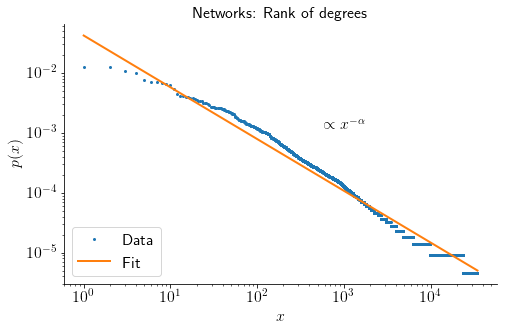

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = px

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x
y_ = px_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim(1,1000)
# ax.set_ylim(10**(-5),1.2)

ax.set_xlabel(r'$x$')#,labelpad=0)
ax.set_ylabel(r'$p(x)$')
ax.set_title('Networks: Rank of degrees')

x_annot_formula = 0.6
y_annot_formula = 0.6
ax.annotate(r'$\propto x^{-\alpha}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)

# Autocorrelation function

Note that we are taking the $\log x$ to calculate the autocorrelation (this leads to a more conservative estimation of $\tau^*)$

In [6]:
np.random.seed(42)

nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(np.log(x_data),nrep=nrep,q=[q1,q2])
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)



Autocorrelation time:  153


Text(0.8,0.6,'$\\tau^*=153$')

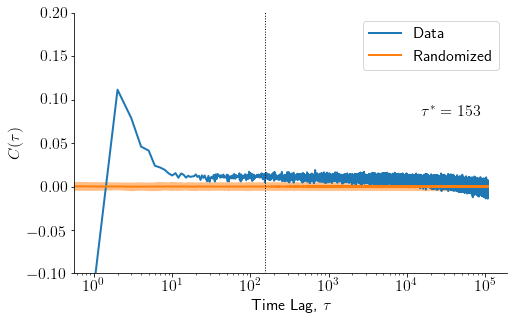

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5
## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Data')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)



## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Randomized')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
ax.legend(loc='upper right')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$')#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$')
ax.set_ylim(-0.1,0.2)


x_annot_tau = 0.8
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')




# Subsampling the data

### p-value for the original dataset

In [8]:
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value

x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Original dataset. N = 215440
Empirical p-value from 100 synthetic datasets:  0.0


### p-value from subsampled dataset

Note that the subsampling generates different datasets each time; therefore there will be variability in the measured p-value

In [9]:

p_sub = 1./tau_star ## 0 ... 1 (keep nothing ... keep all); we set 1/tau_star
N_sub = int(p_sub*N)
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value


## subsample -- take N_sub samples from x_data without replacement
x_data_sub = np.random.choice(x_data,size=N_sub,replace=False)
x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print(r'Subsampled dataset: n = %s (n/N ~ %s)'%(N_sub,p_sub)) 
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Subsampled dataset: n = 1408 (n/N ~ 0.006535947712418301)
Empirical p-value from 100 synthetic datasets:  0.0
